Adrià Melús - 1527144

# Pràctica 3 d'APC

## 1.Introducció

Elon Musk és considerada la persona amb més diners del planeta actualment; és el director executiu de la empresa aerospacial SpaceX i de la d'automòvils elèctrics Tesla, i fa poc va rebre el títol de la persona del any per part de la revista Time. 

Elon Musk també és algú que destaca per la seva activitat a Twitter, on publica memes o frases que deixen a tot el món pensant si realment les diu en serio. Mai està massa ocupat per comentar alguna broma o un pensament espontani. Tot i això, els seus intents per semblar graciós, per lo general acaben mosrant la seva irresponsabilitat al publicar tantes afirmacions confuses, insensibles o incorrectes.

En honor al seu nou títol, que segons la publicació és otorgat a "la persona o persones que més han afectat les notícies i les nostres vides, cap a bé o cap a malament".

<img src="../figures/elon1.jpg">

Aquest és l'informe de  l'anàlisi de resultats en aprenentatge computacional d'una base de dades de kaggle que conté més de 25.000 tweets d'Elon Musk: https://www.kaggle.com/taruntiwarihp/elon-musk-tweets

El propòsit principal d'aquest anàlisi és el de predir el sentiment d'un tweet segons sigui positiu o negatiu:

<img src="../figures/positive-negative.jpg">

Following topics would be covered as an outline for this article:

Data cleaning and preparation.
Analysis of the data.
Analysis and preprocessing text with NLTK.
Resampling data.
Model creation to predict sentiment.


### LLibreries

Per aquest projecte haurem de instalar les seguents llibreries:

Matplotlib, seaborn i wordcloud per la visualització gràfica de dades.

Pandas i numpy pel tractament d'informació.

SkLearn per l'entrenament dels nostres models.

NLTK pel processament de text.

imblearn pel "resampling" de la informació.

In [4]:
# Import 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import scikitplot as skplt
import plotly.graph_objs as go
import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud, STOPWORDS
from prettytable import PrettyTable
from plotly.offline import iplot

from imblearn.combine import SMOTETomek

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

nltk.download('stopwords', quiet=True);
nltk.download('vader_lexicon', quiet=True);

## 2. Informació de les dades

Primer de tot observarem detalladament les dades i les entendrem. A continuació, si és necessari, netejarem el dataset i el prepararem per analitzar-lo.

In [5]:
# Carregar el Dataset

dataset = "../dataset/Elon Musk.csv"
dades = pd.read_csv(dataset)

# Eliminem la primera columna perquè es tracta d'un index que no ens fa falta
dades.drop(dades.columns[0], inplace = True, axis = 1)
dades.head(1)


,tweets,sentiment
0,@elonmusk @realfuckingnews @business Ancient c...,pos


In [6]:
# Quantes files i columnes hi ha al dataset? Cada fila representa un tweet
print("Hi ha {} columnes".format(dades.shape[1]), "i {} files.".format(dades.shape[0]))
print(dades.dtypes)

Hi ha 2 columnes i 25757 files.
tweets       object
sentiment    object
dtype: object


Com es pot observar, aquest dataset conté 25757 files i 2 columnes. Cada fila correspon a un tweet i inclou dues variables:

tweets: Variable de tipus object amb el contingut d'un tweet que esmenta @elonmusk.
sentiment: Variable de tipus object que indica el sentiment del tweet. L'atribut sentiment pot prendre dos valors: pos (positiu) o neg (negatiu)

Comprovem si hi ha cap valor nul:

In [7]:
null_counts = dades.isnull().sum()
null_counts[null_counts>0]

Series([], dtype: int64)

No s'ha trobat cap valor null o Nan, per tant no farà falta eliminar cap fila, de moment.

## 3. Anàlisi de la informació

In [8]:
dades.describe(exclude=[np.number]).drop("count")

,tweets,sentiment
unique,25418,2
top,@Twitter @elonmusk,pos
freq,67,22725


Hem vist que el dataset té tan sols dues variables rellevants on una és categòrica. Com es pot observar, hi ha 25.418 tweets únics i dos valors únics (pos i neg) de la variable sentiment.

Ara anem a visualitzar gràficament la distribució de la variable objectiu sentiment 

In [9]:
# Funció per la visualització en un gràfic de barres per la distribució de l'atribut x que es pasa com a paràmetre 
def plot_distributionCount(x, data):
    plt.subplots(figsize=(6, 4))
    sns.countplot(x=x, data=data, order=data[x].value_counts().index, palette='icefire_r')
    plt.xlabel('sentiment')
    plt.tight_layout()
    plt.show()

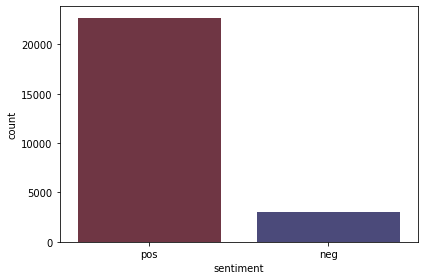

In [10]:
plot_distributionCount('sentiment',dades)

Com es pot observar, l'atribut sentiment prèn el valor positiu (88%) amb molta més freqüència que el negatiu (12%).

### 3.1. Anàlisi i neteja de tweets

Una vegada hem analitzat la informació i les variables de les que disposem, començarem a analitzar el text dels tweets. El tractament de tweets és important per tal de que posteriorment el text encaixi amb un model d'aprenentatge computacional  correctament.  

In [11]:
pd.set_option('max_colwidth', 700)
dades[['tweets', 'sentiment']].sample(5)

,tweets,sentiment
7904,Otro intento fallido de @SpaceX y @elonmusk https://t.co/MpPCtNXSsX,pos
7533,@elonmusk @NASA Thank you!,pos
14486,$MMEX oil and gas company that is moving into the solar and hydrogen space. Located in TX 😎 https://t.co/GhknmsqNlG https://t.co/KdvWDozpfL,pos
9013,@elonmusk @ERCOT_ISO Dreming of a tesla model 3,pos
7961,@SpaceX @elonmusk simulation + @elonmusk x PLTR = π,pos


Natural Language Toolkit (NLTK) és un conjunt de biblioteques i programes que ajuden al processament del llenguatge natural. Utilitzarem les eines que proporciona NLTK per "netejar" els tweets, és a dir, dividir-los en paraules i controlar la puntuació, els números, les @ o les paraules buides.

La següent funció converteix el tweet que es passa com a paràmetre en un text en minúscula, esborrra els numeros i puntuacions i separa el text en diferents paraules. L'idioma dels tweets és l'anglès, i un dels passos de la funció és eliminar les anomenades "stop words" d'aquest idioma. Les stop words son paraules freqüentment utilitzades (com preposicions) però que no aporten significat al tweet i per tant no són rellevants en aquest cas. També s'eliminen els símbols com l'@ i la paraula "elonmusk" que es troben a TOTS els tweets, per tant, no aporten iformació rellevant per cada tweet. 

In [42]:
# Converteix el tweet a un text net sense @
def preProcessingTweet(tweet):
    text = tweet.lower()
    
    # treure puntuacio
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # treure números
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    #treure @
    text = [word for word in text if not any ("@" == c for c in word)]

    text = RegexpTokenizer(r'\w+').tokenize(str(text))
    
    # treure stop words
    text = [x for x in text if x not in stopwords.words('english')]

    #treure elonmusk
    text = [x for x in text if x != "elonmusk"]
    
    #treure enllaços https
    text = [x for x in text if x != "https"]

    
    #treure realfuckingnews
    text = [x for x in text if x != "realfuckingnews"]
    
    # treure paraules buides
    text = [t for t in text if len(t) > 0]
    
    # unó de tot
    tweetNet = " ".join(text)
    return(tweetNet)

In [43]:
dades['tweetsNets'] = dades['tweets'].apply(lambda x: preProcessingTweet(x))

In [44]:
pd.set_option('max_colwidth', 1600)
dades.sample(8)

,tweets,sentiment,tweetsNets
10480,#Bitcoin has it’s own emoji\n #Dogecoin not yet.. @elon your tweet could solve it..\n\nLet’s all make it happen!… https://t.co/lgt6xwamtt,pos,bitcoin xa0 emoji n dogecoin yet elon tweet could solve n nlet make happen
13977,Lool https://t.co/b3FiwFHrYV,pos,lool
8463,@BTC_Archive @SEC_News @JanetYellen @Lagarde @Grayscale @elonmusk @michael_saylor @ecb @federalreserve bitcoin shou… https://t.co/0Io5lSde0f,pos,btc_archive sec_news janetyellen lagarde grayscale michael_saylor ecb federalreserve bitcoin shou
2386,"@elonmusk you have not forgotten about FIL, a promising project",pos,forgotten fil promising project
19165,@elonmusk @business D. Its high energy use is not a flaw of the system either. It’s by design and will (partly) inc… https://t.co/LuOCrDgn6d,pos,business high energy use flaw system either design partly inc
25416,@broadhead77 @danheld @elonmusk thanks ur best,pos,danheld thanks ur best
23601,@business @elonmusk Zaho say the dogecoin is a big scam,neg,business zaho say dogecoin big scam
4361,#JeffBezos now the richest man in the world after #ElonMusk gets overwhelmed with #Tesla \nAm i right???,pos,jeffbezos richest man world gets overwhelmed tesla nam right


Hem afegit una nova columna amb els tweets nets, podem ara sí, observar el text per buscar dades rellevants sobre aquests,

### WordCloud per paraules positives o negatives

Una vegada hem netejat els tweets, podem donar una ullada a les dades de nou per buscar dades rellevants, com les paraules que més es repeteixen i les possibles relacions amb el sentiment del tweet. 

In [45]:
stop_words = set(STOPWORDS)
stop_words.update([x.lower() for x in list(dades["tweetsNets"][dades["tweetsNets"].notnull()].unique())])

In [46]:
def wordCloud(data, background_color, title):
    plt.figure(figsize = (10,10))
    wc = WordCloud(background_color = background_color, max_words = 500, stopwords = stop_words, max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc, interpolation="bilinear")
    plt.title(title)
    plt.axis('off')

Separem els tweets positius i negatius:

In [47]:
df = dades[['tweets','tweetsNets','sentiment']]

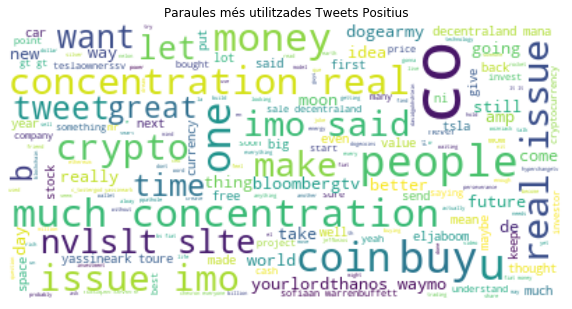

In [48]:
tweets_positius = df[df['sentiment'] == 'pos']
wordCloud(tweets_positius['tweetsNets'], 'white', "Paraules més utilitzades Tweets Positius")

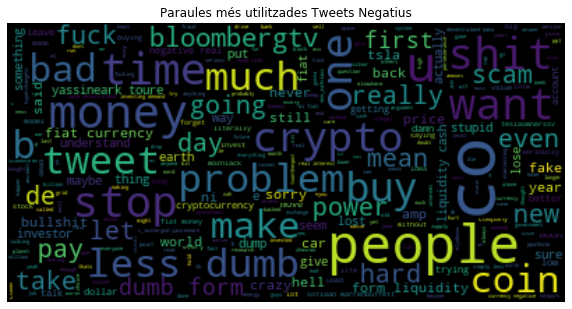

In [49]:
tweets_negatius = df[df['sentiment'] == 'neg']
wordCloud(tweets_negatius['tweetsNets'], 'black', "Paraules més utilitzades Tweets Negatius")

Després de fer les primeres proves anmb worcloud, es va haver de millorar la funció prePreProcessingTweet per eliminar també la paraula "https", que fa referència a la gran quantitat d'enllaços que es troben freqüentment a tot tipus de tweets, ja siguin positius o negatius. El matex per la paraula "realfuckingnews", que com ha indicat wordCloud no és necessariament una paraula que indiqui negativitat en el tweet.

Una vegada realitzada aquesta millora, podem observar a les imatges que ha generat l'eina wordCLoud els termes més repetits en els tweets positius i negatius.

## 4.Tractament de les dades

Abans de començar a crear el nostre model de predicció de sentiment, necessitem tractar les dades.

Primer de tot observem la distribució dels tweets respecte el seu sentiment:

Positius: 22725
Negatius: 3032


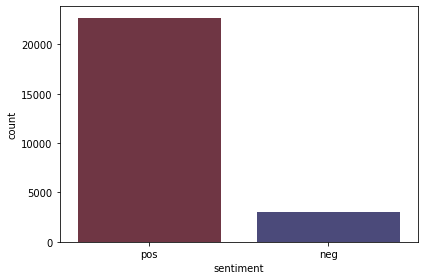

In [51]:
target_count = df['sentiment'].value_counts()
print("Positius:",  target_count[0])
print("Negatius:",  target_count[1])

plot_distributionCount('sentiment',df)

La informació respecte els sentiments no està equilibrada. Això pot suposar un inconvenient alhora de la classificació ja que, per exemple, el model podria obtenir aprop d'un 85% només predint sempre positiu. Per tal de solucionar aquest desbalanç de dades, utilitzarem la llibreria imblearn.

La seguent classe SMOTETomek és una classe de la llibreria imblearn que combina tècniques de over-sampling i under-sampling:

In [54]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='auto')

## Resultats

## 6. Conclusions


In [ ]:
## Conclusions